<div class="alert alert-block alert-info">
<span style="color: rgb(0,53,91);">
<center><img src="https://www.redage.org/sites/default/files/styles/large/public/img-logo-institucion/logo_iteso.jpg?itok=IzloBJS1" style="width:500px;height:142px;" title="Logo ITESO"></center>

<font face = "Times New Roman" size = "6"><b><center>Programacion para Mineria de Datos</center></b></font>
<font face = "Times New Roman" size = "5"><b><center>Regresion Lineal</center></b></font>

<font face = "Times New Roman" size = "5"><b><center>Proyecto Final</center></b></font>
<div align="right"><font face = "Times New Roman" size = "2">nombres: Angel Aceves Manzo</font></div>
<div align="right"><font face = "Times New Roman" size = "2"> Jorge Arturo Ponce Martin</font></div>
<div align="right"><font face = "Times New Roman" size = "2"> Jesus Vargas Pacheco</font></div>
</span></div>

In [38]:
#####################################################
#
# APLICAR Regresión lineal a datos preprocesados con PCA
#
#####################################################
# Deben cargarse los archivos
# - T_train_final_objetivo.csv
# - T_test_final_objetivo.csv"
# - pca_pipe_num.joblib
# - pca_metadata.json
# Devolverá
# expected_columns.json (columnas que deberán tener datos que nunca ha visto)
# modelo_reg_lineal.pkl (modelo ya entrenado)
#####################################################

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
##################################################################################################
Train = pd.read_csv("../../01_preprocessing_results/preprocessing/T_train_final_objetivo.csv")
Test = pd.read_csv("../../01_preprocessing_results/preprocessing/T_test_final_objetivo.csv")
##################################################################################################

X_train = Train.iloc[:, :-1]
y_train = Train.iloc[:, -1].to_numpy(dtype=float)

X_test = Test.iloc[:, :-1]
y_test = Test.iloc[:, -1].to_numpy(dtype=float)

SEP = "___" # Con esto encuentra las columnas Categoricas (One Hot)

In [39]:
def is_binary_series(s: pd.Series):
    vals = pd.unique(s.dropna())
    return set(vals).issubset({0,1}) or set(vals).issubset({0.0,1.0})

def prefix_of(col: str, sep=SEP):
    return col.split(sep, 1)[0] if sep in col else None

def build_nominal_blocks_by_prefix(X: pd.DataFrame, sep=SEP):
    blocks = {}
    for c in X.columns:
        if sep in c and is_binary_series(X[c]):
            blocks.setdefault(prefix_of(c, sep), []).append(c)
    # respeta orden del CSV
    for k,v in blocks.items():
        blocks[k] = [c for c in X.columns if c in set(v)]
    return blocks


In [40]:
# 1) --- PRECOMPUTA CON TRAIN ---
blocks = build_nominal_blocks_by_prefix(X_train, SEP)
drop_cols = [cols[0] for cols in blocks.values() if len(cols) >= 2]  # primera de cada bloque

# 2) --- PIPELINE SIN CLASES (usa ColumnTransformer para dropear fijo) ---
arreglar_despeje = ColumnTransformer(
    transformers=[("drop_nominal_bases", "drop", drop_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

mi_regresion_lineal = Pipeline([
    ("dropper", arreglar_despeje),
    ("linreg", LinearRegression(fit_intercept=True)),
])

# 3) --- FIT & PRED ---
mi_regresion_lineal.fit(X_train, y_train)

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('dropper', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('drop_nominal_bases', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [41]:
# Intercepto y coeficientes del modelo dentro del pipeline
intercepto = mi_regresion_lineal.named_steps["linreg"].intercept_
coefs = mi_regresion_lineal.named_steps["linreg"].coef_

# Nombres de columnas después del dropper (lo más directo)
feature_names = mi_regresion_lineal.named_steps["dropper"].get_feature_names_out(X_train.columns)

# Mostrar los estimadores beta_0,beta_1,...,beta_p
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
print("Intercepto (beta0):", intercepto)
print(coef_df)

Intercepto (beta0): 747.3873825211313
                              feature         coef
0                                 PC1  1016.971407
1                                 PC2   -55.523734
2                                 PC3   -62.734242
3                                 PC4  -149.889395
4                                 PC5   370.333893
5                                 PC6   -61.708430
6                                 PC7    29.555564
7                                 PC8  -784.727284
8                       Gender___male    49.549310
9                      Gender___other  -293.741558
10                      City___ankara   106.316018
11                     City___antalya   162.453395
12                       City___bursa    85.314220
13                   City___eskisehir   -41.017427
14                   City___gaziantep   122.502780
15                    City___istanbul   188.908369
16                       City___izmir    71.618171
17                     City___kayseri    23.

In [42]:
###### Guardado del modelo

import joblib, json, time

# guarda el pipeline completo (dropper + LinearRegression)
joblib.dump(mi_regresion_lineal, "modelo_reg_lineal.pkl")

# guarda el orden/esperado de columnas de entrenamiento
expected_cols = X_train.columns.tolist()
with open("expected_columns.json", "w", encoding="utf-8") as f:
    json.dump({"columns": expected_cols, "saved_at": time.strftime("%Y-%m-%d %H:%M:%S")}, f)

print("Artefactos guardados:", "modelo_reg_lineal.pkl", "expected_columns.json")


Artefactos guardados: modelo_reg_lineal.pkl expected_columns.json


In [43]:
import os, zipfile, glob

# Carpeta destino en tu PC
dst_dir = r"mi_regresion_lineal"
os.makedirs(dst_dir, exist_ok=True)
zip_path = os.path.join(dst_dir, "mi_reg_lin_artifacts_bundle.zip")

# Archivos que quieres incluir (ajusta si te falta alguno)
candidates = [
    "modelo_reg_lineal.pkl",
    "expected_columns.json",
]

present = [f for f in candidates if os.path.exists(f)]
# Si quieres incluir una carpeta (p. ej., 'sample_data'), descomenta:
# for root, _, files in os.walk("sample_data"):
#     for f in files:
#         present.append(os.path.join(root, f))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in present:
        zf.write(f, arcname=os.path.basename(f))  # guarda sin subcarpetas

print("ZIP creado en:", zip_path)
print("Incluidos:", present)


ZIP creado en: mi_regresion_lineal\mi_reg_lin_artifacts_bundle.zip
Incluidos: ['modelo_reg_lineal.pkl', 'expected_columns.json']


In [44]:
# ==== PREDICCIÓN CORRECTA ====
y_pred = mi_regresion_lineal.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("MAE:", mae)
print("R²:", r2)
print("RMSE:", rmse)


MSE: 1881446.1989210777
MAE: 533.0901578558772
R²: 0.5038629133578201
RMSE: 1371.6581931811868


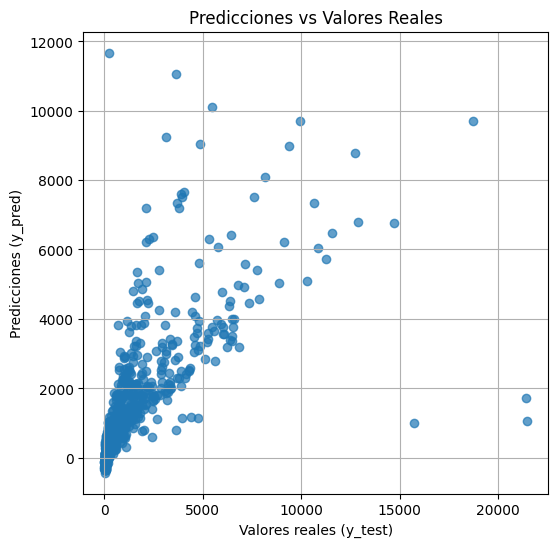

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Predicciones vs Valores Reales")
plt.grid(True)
plt.show()


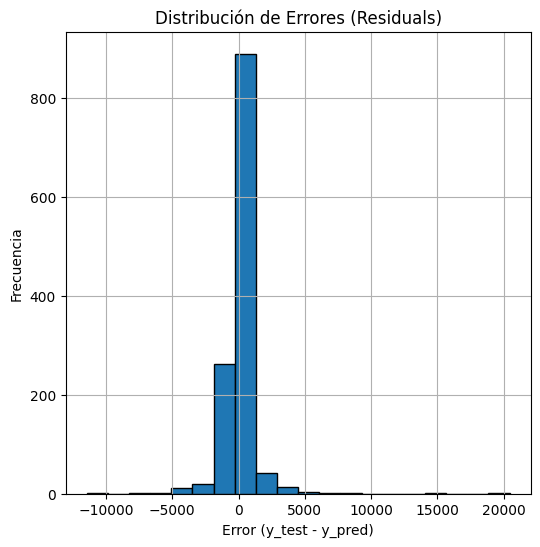

In [46]:
residuals = y_test - y_pred

plt.figure(figsize=(6,6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel("Error (y_test - y_pred)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores (Residuals)")
plt.grid(True)
plt.show()
